Inspired by Brian B. Busemeyer's [talk][1].
[1]: https://paul-st-young.github.io/algorithms/algorithm/Compressed-Sensing-Brian-Busemeyer/

# Code

In [1]:
import numpy as np
import scipy.optimize as op

def setup_linprog(basis_change_matrix,measurements):
    """ Generate compressed sensing input for a linear program solver. 
      Stolen from BB :P """
    num_measurements = basis_change_matrix.shape[0]
    signal_size      = basis_change_matrix.shape[1]

    coefs = np.ones(2*signal_size)
    coefs[:signal_size] = 0

    ineq_mat = np.identity(2*signal_size)
    ineq_mat[signal_size:,signal_size:] = -np.identity(signal_size)
    ineq_mat[:signal_size,signal_size:] = -np.identity(signal_size)
    ineq_mat[signal_size:,:signal_size] = -np.identity(signal_size)

    eq_mat = np.zeros((2*signal_size,2*signal_size))
    eq_mat[:num_measurements,:signal_size] = basis_change_matrix
    eq_vec = np.zeros(2*signal_size)
    eq_vec[:num_measurements] = measurements
    return coefs,ineq_mat,eq_mat,eq_vec
# end def

In [2]:
def comp_sense(measurements,measurement_basis):
    measurement_size,signal_size = measurement_basis.shape
    coefs,ineq_mat,eq_mat,eq_vec = setup_linprog(measurement_basis,measurements)
    result = op.linprog(
        coefs,
        ineq_mat,
        np.zeros(2*signal_size),
        eq_mat,
        eq_vec,
        bounds=(-np.inf,np.inf),
        options={'maxiter':10000}
    )
    return result.x[:signal_size]
# end def

# Demonstration

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

### generate known sparse signal in *sparse* space then convert to *real* space

In [4]:
signal_size = 100

# generate random signal
signal = np.random.randn(signal_size)

# choose how many entries to be zero
signal_sparsity = 0.05
num_zero_signal = signal_size - int(round(signal_size*signal_sparsity))

# choose entries to zero out randomly
zeros = np.random.choice(range(len(signal)),num_zero_signal,replace=False)
signal[zeros] = 0
original_signal = signal.copy()

In [5]:
# transform signal to real space
signal_basis = np.random.randn(signal_size,signal_size)/signal_size
real_signal  = np.dot(signal_basis,signal)

### generate measurements in real space

In [6]:
# randomly choose some fraction of signal to measure
frac_measurements = 0.3
num_measurements  = int(round(frac_measurements * signal_size))
measure_idx = np.random.choice(range(signal_size),num_measurements,replace=False)
real_measurements = real_signal[measure_idx]
# save measurement basis elements
measurement_basis = signal_basis[measure_idx,:]

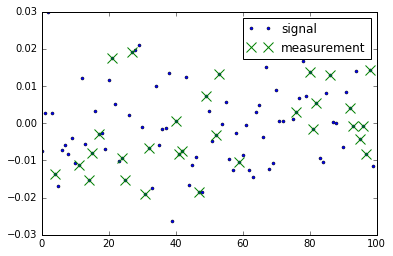

In [7]:
plt.plot(real_signal,"o",ms=3,label="signal")
plt.plot(measure_idx,real_measurements,"x",ms=10,mew=1,label="measurement")
plt.legend()

### let the magic happen

In [8]:
result = comp_sense(real_measurements,measurement_basis)

### did the magic work?

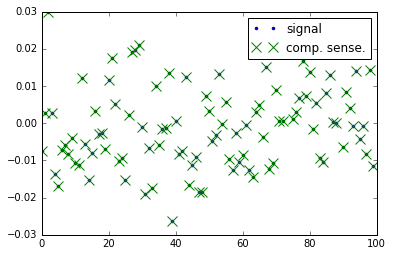

In [9]:
plt.plot(real_signal,"o",ms=3,label="signal")
plt.plot(np.dot(signal_basis,result),"x",ms=10,mew=1,label="comp. sense.")
plt.legend()